In [1]:
pip install -r requirements.txt --user


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import scipy.io
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

def dataloader(path):
    data = scipy.io.loadmat(path)
    AF = data['AF']
    modified_rows1 = AF[:-2]
    last_rows1 = AF[-2:]
    CF = data['CF']
    concatenated_array = np.concatenate((modified_rows1, CF,last_rows1), axis=0)
    new=concatenated_array
    u, count = np.unique(new[-1], return_counts=True)
    a = u[np.logical_or(count < 2, count > 2)]
    c = new[:, np.isin(new[-1], a, invert=True)]
    x = c[0:-2]; y = c[-2]; w = c[-1];
    return x.T, y.T, w.T, data['CF_info']

def calculate_accuracy(arr1, arr2):
    count = sum(1 for itr1, itr2 in zip(arr1, arr2) if itr1 == itr2)
    return count / len(arr1)

def normalization(feats):
    df = pd.DataFrame(feats)
    scaler = StandardScaler()
    x_new = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return x_new

def make_partitions(arr_words, arr_labels):
    v = []
    temp = []

    for i in range(len(arr_words) - 1):
        word = arr_words[i]
        next_word = arr_words[i + 1]
        temp.append(arr_labels[i])

        if word != next_word or i == len(arr_words) - 2:
            if i == len(arr_words) - 2:
                temp.append(arr_labels[i + 1])

            numpy_temp = np.array(temp)
            temp_max = np.amax(numpy_temp)
            numpy_temp = np.divide(numpy_temp, temp_max)
            v = np.concatenate((v, numpy_temp), axis=None)
            temp.clear()

    v1 = [1 if i == 1 else 0 for i in v]
    return v1
    
fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
original_dim = 38
train_path = filee; test_path = filee.replace('train','test')
xtrain, ytrain, wtrain1, info_train1 = dataloader(train_path);
xtest, ytest, wtest1, info_test1 = dataloader(test_path);
xtest= normalization(xtest)
xtrain= normalization(xtrain)

woPP=[]; wPP=[]
input_shape1 = (19,1)
input_shape2 = (38,1)
temperature = 0.03
learning_rate=0.001

2023-06-16 07:52:59.583903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
pca = PCA(2)
pca_result = pca.fit_transform(xtrain)

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

/project/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


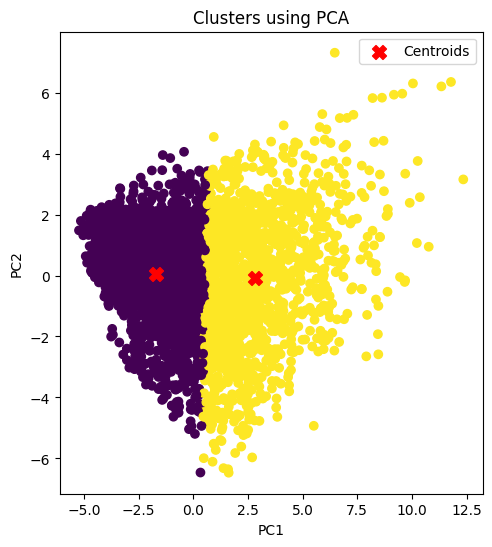

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')
plt.title('Clusters using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

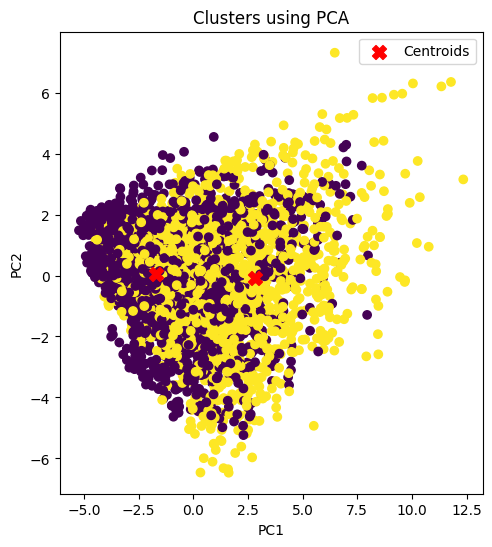

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=ytrain, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')
plt.title('Clusters using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

In [23]:
print(calculate_accuracy(ytrain,labels))

0.6057013118062563


In [25]:
xtrain=xtrain.to_numpy()

In [27]:
from sklearn.cluster import KMeans

def constrained_kmeans(data, k):
    kmeans.fit(data)
    centroids = kmeans.cluster_centers_
    cluster_assignments = kmeans.predict(data)
    for i in range(0, len(cluster_assignments), 2):
        if cluster_assignments[i] == cluster_assignments[i + 1]:
            other_cluster = 1 - cluster_assignments[i]
            dist_to_current = np.linalg.norm(data[i] - centroids[0])
            dist_to_other = np.linalg.norm(data[i] - centroids[1])
            dist_to_current2 = np.linalg.norm(data[i+1] - centroids[0])
            dist_to_other2 = np.linalg.norm(data[i+1] - centroids[1])
            
            min_distance = min(dist_to_current, dist_to_other, dist_to_current2, dist_to_other2)

            if (min_distance==dist_to_current):
                cluster_assignments[i + 1] = other_cluster
            elif (min_distance==dist_to_current2):
                cluster_assignments[i] = other_cluster
            elif (min_distance==dist_to_other):
                cluster_assignments[i] = other_cluster
            else:
                cluster_assignments[i + 1] = other_cluster
    return centroids, cluster_assignments

k = 2
centroids, cluster_assignments = constrained_kmeans(pca_result, k)
acc=calculate_accuracy(ytrain,cluster_assignments)
if acc<(0.5):
    labels2 = np.logical_not(cluster_assignments).astype(int)
else:
    labels2=cluster_assignments
print(labels2)
calculate_accuracy(labels2,ytrain)

/project/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 0 ... 1 0 1]


0.5812310797174571

In [32]:
pca_result[0].shape

(2,)

In [29]:
from sklearn.metrics.pairwise import chi2_kernel

# Assuming 'xtrain' and 'ytrain' are NumPy arrays of the specified shapes

# Calculate the chi-square similarity between 'xtrain' and 'ytrain'
similarity = chi2_kernel(pca_result[1], labels2.reshape(-1,1))

print("Similarity shape:", similarity.shape)
print("Similarity matrix:")
print(similarity)


ValueError: Expected 2D array, got 1D array instead:
array=[ 4.05671757 -1.07966049].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.